In [1]:
import pathlib
import pprint

In [2]:
import math
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.float_format = '{:.2f}'.format

### 使用するデータ
https://www.kaggle.com/c/tabular-playground-series-mar-2022/overview

このコンテストでは、米国の主要大都市圏での12時間の交通流を予測します。時間、空間、および方向性の機能により、道路のネットワーク全体の相互作用をモデル化する機会が得られます。

+ train.csv- 1991年4月から9月までの65の道路での交通渋滞の測定で構成されるトレーニングセット。
    + row_id-このインスタンスの一意の識別子
    + time-各測定が行われた20分間
    + x-道路の東西中点座標
    + y-道路の南北中点座標
    + direction-車道の進行方向。EBたとえば、「東行き」の移動をSW示し、「南西」の移動方向を示します。
    + congestion-1時間ごとの道路の渋滞レベル。ターゲット。輻輳測定値は、0〜100の範囲に正規化されています。
+ test.csv-テストセット。1991年9月30日の座標位置と進行方向によって識別される道路の1時間ごとの予測を行います。
+ sample_submission.csv-正しい形式のサンプル送信ファイル

In [4]:
p_temp = pathlib.Path('../data')
pprint.pprint(list(p_temp.iterdir()))

[PosixPath('../data/.DS_Store'),
 PosixPath('../data/test.csv'),
 PosixPath('../data/train.csv'),
 PosixPath('../data/sample_submission.csv')]


### 要約統計量
異常な外れ値などはなし。timeという時系列データがあり、このままだと予測を出せないので、`datetime`を使って特徴量を追加する。また、`direction`はカテゴリカル特徴量なので、値に変換する。

In [5]:
train = pd.read_csv('../data/train.csv')
train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [6]:
train.describe()

,row_id,x,y,congestion
count,848835.00,848835.00,848835.00,848835.00
mean,424417.00,1.14,1.63,47.82
std,245037.70,0.80,1.09,16.80
min,0.00,0.00,0.00,0.00
25%,212208.50,0.00,1.00,35.00
50%,424417.00,1.00,2.00,47.00
75%,636625.50,2.00,3.00,60.00
max,848834.00,2.00,3.00,100.00


In [7]:
import datetime

In [8]:
train['year']=0
train['month']=0
train['day']=0
train['hour']=0
train['minute']=0
train['second']=0

1991-04-01 00:00:00

In [9]:
for index,row in train.iterrows():
    date_str = row['time']
    date_dt = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    train.loc[index,'year']=date_dt.year
    train.loc[index,'month']=date_dt.month
    train.loc[index,'day']=date_dt.day
    train.loc[index,'hour']=date_dt.hour
    train.loc[index,'minute']=date_dt.minute
    train.loc[index,'second']=date_dt.second

In [10]:
train = train.drop('time',axis=1)

In [11]:
direction_dict = train['direction'].unique()
print(direction_dict)

['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [12]:
train = train.replace({'direction':{'EB':0,'NB':1,'SB':2,'WB':3,'NE':4,'SW':5,'NW':6,'SE':7}})

In [13]:
train.head()

,row_id,x,y,direction,congestion,year,month,day,hour,minute,second
0,0,0,0,0,70,1991,4,1,0,0,0
1,1,0,0,1,49,1991,4,1,0,0,0
2,2,0,0,2,24,1991,4,1,0,0,0
3,3,0,1,0,18,1991,4,1,0,0,0
4,4,0,1,1,60,1991,4,1,0,0,0


In [14]:
train.describe()

,row_id,x,y,direction,congestion,year,month,day,hour,minute,second
count,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00,848835.00
mean,424417.00,1.14,1.63,2.43,47.82,1991.00,6.49,15.70,11.48,20.01,0.00
std,245037.70,0.80,1.09,1.89,16.80,0.00,1.70,8.79,6.93,16.33,0.00
min,0.00,0.00,0.00,0.00,0.00,1991.00,4.00,1.00,0.00,0.00,0.00
25%,212208.50,0.00,1.00,1.00,35.00,1991.00,5.00,8.00,5.00,0.00,0.00
50%,424417.00,1.00,2.00,2.00,47.00,1991.00,6.00,16.00,11.00,20.00,0.00
75%,636625.50,2.00,3.00,4.00,60.00,1991.00,8.00,23.00,17.00,40.00,0.00
max,848834.00,2.00,3.00,7.00,100.00,1991.00,9.00,31.00,23.00,40.00,0.00


### 予測の準備する


In [15]:
y=train['congestion']
X=train.drop(['congestion','row_id'],axis=1)

In [16]:
y.head()

0    70
1    49
2    24
3    18
4    60
Name: congestion, dtype: int64

In [17]:
X.head()

,x,y,direction,year,month,day,hour,minute,second
0,0,0,0,1991,4,1,0,0,0
1,0,0,1,1991,4,1,0,0,0
2,0,0,2,1991,4,1,0,0,0
3,0,1,0,1991,4,1,0,0,0
4,0,1,1,1991,4,1,0,0,0


In [18]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.15, random_state=9)

In [19]:
corr = train.corr()
abs(corr['congestion']).sort_values(ascending=False)

congestion   1.00
direction    0.29
hour         0.15
y            0.09
x            0.05
day          0.01
row_id       0.00
month        0.00
minute       0.00
year          NaN
second        NaN
Name: congestion, dtype: float64

# 解釈方法の種類と範囲
いろんなモデルを使う。

In [20]:
rand=0

In [21]:
reg_models = {
        #Generalized Linear Models (GLMs)
    'linear':{'model': linear_model.LinearRegression()}, 
    'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
    linear_model.LinearRegression(fit_intercept=False)) },
    'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                            linear_model.LinearRegression(fit_intercept=False)) },
    'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
    #Trees  
    'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
    #RuleFit
    'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
    #Nearest Neighbors
    'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
    #Ensemble Methods
    'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
    #Neural Networks
    'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, early_stopping=True, random_state=rand)}
}

In [22]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test, y_test_pred)

In [23]:
linreg_mdl = sm.OLS(y_train, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             congestion   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                 1.456e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:32:33   Log-Likelihood:            -3.0118e+06
No. Observations:              721509   AIC:                         6.024e+06
Df Residuals:                  721501   BIC:                         6.024e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.6796      0.024    111.769      0.000       2.633       2.727
y             -0.8005      0.017    -46.646      0.000      -0.834      -0.767
direction     -2.8052      0.010   -274.298      0.000      -2.825      -2.785
year           0.0244   4.94e-05    492.686      0.000       0.024       0.024
month          0.0167      0.011      1.525      0.127      -0.005       0.038
day            0.0141      0.002      6.680      0.000       0.010       0.018
hour           0.3549      0.003    132.713      0.000       0.350       0.360
minute     -2.879e-05      0.001     -0.025      0.980      -0.002       0.002
second              0          0        nan        nan           0           0
==============================================================================
Omnibus:                     6259.027   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4478.504
Skew:                           0.083   Prob(JB):                         0.00
Kurtosis:                       2.651   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## summayからわかること
+ Covariance Type : 共分散の種類（相関関係）、相関関係のレベルがnonrobust
今回はnonrobust
+ R-squared : 決定係数、目的変数のどれくらいを説明できるかを表す
0.9以上	非常によい  
0.7以上0.9未満	よい  
0.5以上0.7未満	あまりよくない  
0.5未満	悪い  
今回は0.124なので悪すぎる
+ Adj. R-squared : 自由度調整済み決定係数、
+ F-statistic : F値、すべての係数がゼロであるという仮説を検定する場合に使う
+ Prob(F-statistic) : F値の現れる確率
+ Log-Likelihood : 対数尤度、尤もらしいか否か、絶対値で考える
+ AIC : 赤池情報量規準、値が小さいほどよい、相対的な評価として用いる
+ BIC : ベイズ情報量規準、上に同じく


## 評価指標
最小二乗法での結果をまずみる
+ RMSE : 小さい方が嬉しい
+ R2 : でかいほうが嬉しい

精度かなりひどい。

In [24]:
reg_metrics=pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train','RMSE_test','R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis',low=1,high=0.3,subset=['RMSE_train','RMSE_test']).background_gradient(cmap='plasma',low=0.3,high=1,subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
knn,9.562820,11.045617,0.566932
random_forest,11.267021,11.294583,0.547190
decision_tree,11.311571,11.340793,0.543477
rulefit,14.110739,14.125405,0.291764
linear_poly,14.998709,15.001927,0.201141
linear_interact,15.402717,15.400636,0.158114
ridge,15.727692,15.733398,0.121340
linear,15.727692,15.733398,0.121340
mlp,15.728127,15.734121,0.121259


In [25]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),'coef': coefs_lm})
coef_df.style.background_gradient(cmap='viridis_r',low=.5, high=0)

,feature,coef
0,x,2.679609
1,y,-0.800470
2,direction,-2.805179
3,year,0.000000
4,month,0.016651
5,day,0.014068
6,hour,0.354869
7,minute,-0.000029
8,second,0.000000


In [26]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),'coef_linear': coefs_lm,'coef_ridge': coefs_ridge})
coef_ridge_df.style.background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,x,2.679609,2.679602
1,y,-0.800470,-0.800469
2,direction,-2.805179,-2.805177
3,year,0.000000,0.000000
4,month,0.016651,0.016651
5,day,0.014068,0.014068
6,hour,0.354869,0.354869
7,minute,-0.000029,-0.000029
8,second,0.000000,0.000000


# 本質的に解釈可能なモデル
## 線形回帰の仮定
### 正規性
日付特徴量が正規分布しているわけがない…
### 独立性
日付特徴量は独立してないなぁ…
### 多重共線性
相関行列、許容誤差測定、分散拡大係数でテストできる。許容誤差測定はよくわからなかったから、分散拡大係数でテストする。

#### 分散拡大係数
ある説明変数がそれ以外の説明変数にどれだけ説明されるかを示す値。VIFは説明変数の数だけ求められることになる。
説明変数間の相関係数(相関係数は共分散を)を使って求める。

VIF=1/(1-r^2)

rは相関係数。


VIF Factor   features
0        1.08          x
1        1.02          y
2        1.09  direction
3       28.26       year
4        1.00      month
5        1.00        day
6        1.00       hour
7        1.00     minute
8         NaN     second


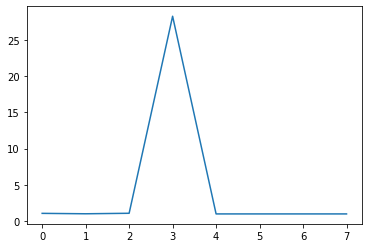

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns

print(vif)

plt.plot(vif["VIF Factor"])

### 等分散性

## いくつか特徴量を落とす

In [28]:
train.head()

,row_id,x,y,direction,congestion,year,month,day,hour,minute,second
0,0,0,0,0,70,1991,4,1,0,0,0
1,1,0,0,1,49,1991,4,1,0,0,0
2,2,0,0,2,24,1991,4,1,0,0,0
3,3,0,1,0,18,1991,4,1,0,0,0
4,4,0,1,1,60,1991,4,1,0,0,0


In [53]:
y_drop=train['congestion']
X_drop=train.drop(['congestion','direction','x','y','row_id','year','month','day','minute','second'],axis=1)

In [54]:
X_train, X_test, y_train, y_test =train_test_split(X_drop, y_drop, test_size=0.15, random_state=9)

In [55]:
linreg_mdl = sm.OLS(y_train, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             congestion   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                 1.583e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:41:28   Log-Likelihood:            -3.0517e+06
No. Observations:              721509   AIC:                         6.103e+06
Df Residuals:                  721507   BIC:                         6.103e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.7338      0.038   1154.222      0.000      43.659      43.808
hour           0.3555      0.003    125.800      0.000       0.350       0.361
==============================================================================
Omnibus:                    17198.855   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8992.988
Skew:                           0.053   Prob(JB):                         0.00
Kurtosis:                       2.463   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns

print(vif)

plt.plot(vif["VIF Factor"])

ValueError: zero-size array to reduction operation maximum which has no identity

In [57]:
y_train_pred = linreg_mdl.predict(X_train.values)
print(math.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

ValueError: shapes (721509,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)